In [21]:
import mne
from mne.time_frequency.multitaper import psd_array_multitaper
from mne.time_frequency.tfr import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import sys

In [2]:
pid = 'sha1'
day = 'Day1'

In [37]:
raw = raw = mne.io.read_raw_brainvision('../0910_continuousTest/0910_continuousTest.vhdr', preload=True)
#filter
raw.notch_filter(freqs=60)
raw.filter(l_freq=3, h_freq=50)
#re-refernce
re_signal = raw.get_data()[raw.ch_names.index('A2')] / 2
new_raw = raw.get_data()
new_raw[raw.ch_names.index('A2')] = re_signal
raw = mne.io.RawArray(new_raw, info=raw.info)
raw.set_eeg_reference(ref_channels=['A2'])
#epoch
events = mne.find_events(raw, stim_channel='TRIGGER')
trigger_table = pd.read_csv('../pre_trigger_table.csv')
trigger_table['sendnum'] = trigger_table['trigger'] * 256
event_id = trigger_table.set_index('label')['sendnum'].to_dict()
for id in ['start', 'questionnaire', 'KVIQ_inst', 'instruction']:
    del event_id[id]
epochs = mne.Epochs(raw, events, event_id, tmin=-1, tmax=4, detrend=1)
task = [epochs['task_left'], epochs['task_right']]

Extracting parameters from ../0910_continuousTest/0910_continuousTest.vhdr...
Setting channel info structure...
Reading 0 ... 1094336  =      0.000 ...  2188.672 secs...
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband atte

In [45]:
C4 = epochs.ch_names.index('C4')
C3 = epochs.ch_names.index('C3')

In [40]:
fmin, fmax = 8, 13
baseline = []
for ch in ['C4', 'C3']:
    base = raw.get_data()[raw.ch_names.index(ch), 381552:392696]
    baseList = []
    for step in range(0, len(base)-500, 500):
        if not np.any(np.abs(base[step:step+500]) > 100e-6):
            psd, freqs = psd_array_multitaper(base[step:step+500], 500, fmin=fmin, fmax=fmax)
            baseList.append(psd)
    baseline.append(np.median(baseList))
baseline

[2.938801633961667e-10, 3.07046119838086e-10]

In [55]:
def TFA(epoch, ch):
    freqs = np.arange(1, 35, 1)
    n_cycles = freqs / 2
    power = tfr_morlet(epoch, freqs=freqs, n_cycles=n_cycles, return_itc=False)
    base = baseline[0] if ch == 'C4' else baseline[1]
    corrected_power = power_baseline_correction(power, base)
    return corrected_power
    #return np.average(corrected_power.data[epochs.ch_names.index(ch)][8:13], axis=0)

Loading data for 15 events and 2501 original time points ...
0 bad epochs dropped
Loading data for 15 events and 2501 original time points ...
0 bad epochs dropped


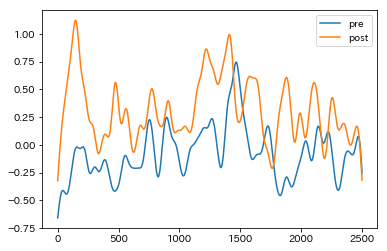

In [58]:
plt.plot(np.average(TFA(task[0][:15], 'C4').data[C4][8:13], axis=0), label='pre')
plt.plot(np.average(TFA(task[0][-15:], 'C4').data[C4][8:13], axis=0), label='post')
plt.legend()

Loading data for 15 events and 2501 original time points ...
0 bad epochs dropped
Loading data for 15 events and 2501 original time points ...
0 bad epochs dropped


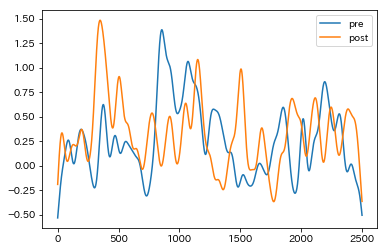

In [59]:
plt.plot(np.average(TFA(task[1][:15], 'C3').data[C3][8:13], axis=0), label='pre')
plt.plot(np.average(TFA(task[1][-15:], 'C3').data[C3][8:13], axis=0), label='post')
plt.legend()

Loading data for 15 events and 2501 original time points ...
0 bad epochs dropped
No baseline correction applied


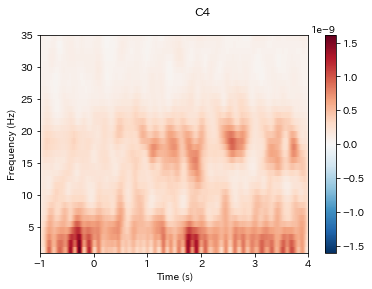

Loading data for 48 events and 2501 original time points ...
0 bad epochs dropped
No baseline correction applied


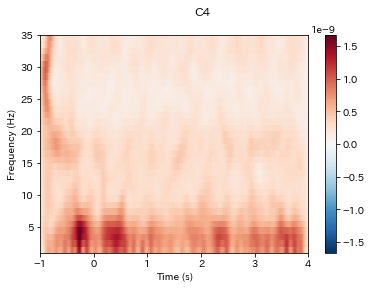

Loading data for 15 events and 2501 original time points ...
0 bad epochs dropped
No baseline correction applied


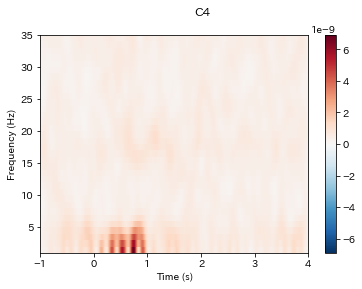

In [52]:
_ = TFA(task[0][:15], 'C4').plot([C4])
_ = TFA(task[0][15:63], 'C4').plot([C4])
_ = TFA(task[0][63:], 'C4').plot([C4])

Loading data for 15 events and 2501 original time points ...
0 bad epochs dropped
No baseline correction applied


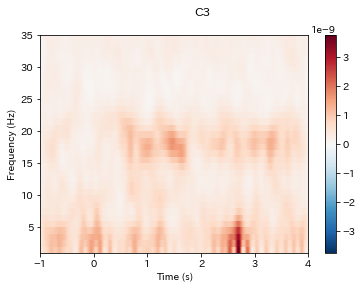

Loading data for 50 events and 2501 original time points ...
0 bad epochs dropped
No baseline correction applied


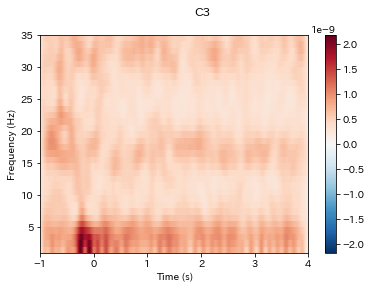

Loading data for 15 events and 2501 original time points ...
0 bad epochs dropped
No baseline correction applied


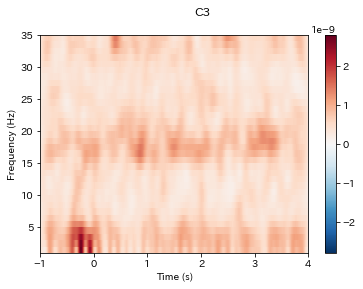

In [53]:
_ = TFA(task[1][:15], 'C3').plot([C3])
_ = TFA(task[1][15:65], 'C3').plot([C3])
_ = TFA(task[1][65:], 'C3').plot([C3])

Loading data for 15 events and 2501 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
Loading data for 15 events and 2501 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)


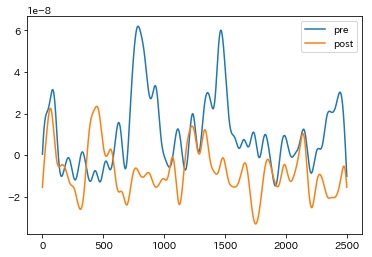

In [10]:
plt.plot(TFA(Mitask_pre[0], 'C4'), label='pre')
plt.plot(TFA(Mitask_post[0], 'C4'), label='post')
plt.legend()

Loading data for 15 events and 2501 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
Loading data for 15 events and 2501 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)


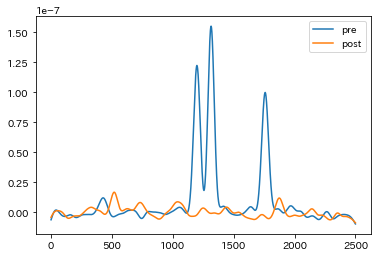

In [11]:
plt.plot(TFA(Mitask_pre[1], 'C3'), label='pre')
plt.plot(TFA(Mitask_post[1], 'C3'), label='post')
plt.legend()

In [12]:
epochs

<Epochs  |   333 events (good & bad), -1 - 4 sec, baseline [None, 0], ~53 kB, data not loaded,
 'KVIQ': 1
 'Mitest_post': 1
 'Mitest_post_relaxleft': 15
 'Mitest_post_relaxright': 15
 'Mitest_post_taskleft': 15
 'Mitest_post_taskright': 15
 'Mitest_pre': 1
 'Mitest_pre_relaxleft': 15
 'Mitest_pre_relaxright': 15
 'Mitest_pre_taskleft': 15
 'Mitest_pre_taskright': 15
 'baseline': 1
 'finish': 1
 'flandars': 1
 'relax_left': 50
 'relax_right': 50
 'rest': 4
 'start': 1
 'task_left': 50
 'task_right': 50
 'training_finish': 1
 'training_start': 1>

In [13]:
def fun(d, m):
    d -= m

Loading data for 15 events and 2501 original time points ...
No baseline correction applied


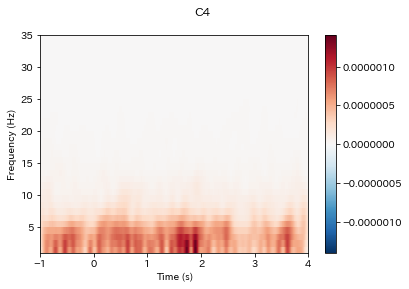

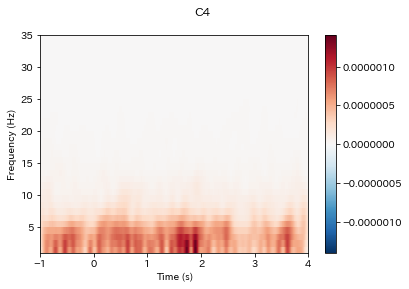

In [54]:
freqs = np.arange(1, 35, 1)
n_cycles = freqs / 2
power = tfr_morlet(Mitask_pre[0], freqs=freqs, n_cycles=n_cycles, return_itc=False)
power.plot([epochs.ch_names.index('C4')])

 ...]

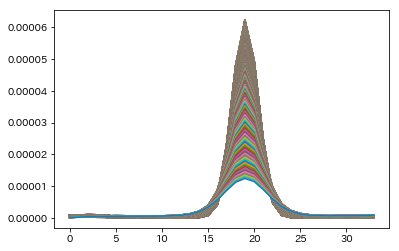

In [24]:
data = power.data
mean = np.mean(data[0:500], axis=-1, keepdims=True)
plt.plot(data[0])

In [25]:
fun(data, mean)

 ...]

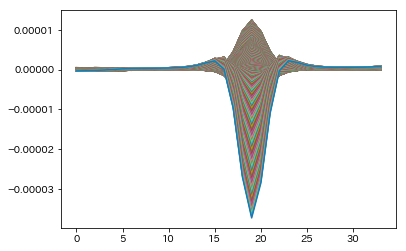

In [26]:
plt.plot(data[0])

No baseline correction applied


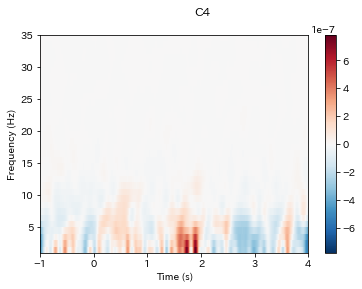

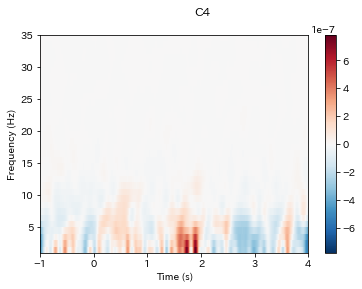

In [30]:
AverageTFR(power.info, data, power.times, power.freqs, power.nave).plot([epochs.ch_names.index('C4')])

In [34]:
def power_baseline_correction(power, baseline):
    """
    power:instance of AverageTFR
    baseline:float
    """
    data = power.data
    mean = baseline
    data = (data - mean) / mean
    return AverageTFR(power.info, data, power.times, power.freqs, power.nave)